A.S. Lundervold, 24.01.2024

# Introduction

This notebook accompanies the notebooks from the fastai course and the fastai book. See the description of Module 2 on Canvas. It steps through an example of downloading and preparing data by searching for images online, then training and deploying an image classifier model. 

The image classifier's task will be to distinguish between pictures taken of Oslo versus Bergen. 

In addition, it introduces the concept of **class activation maps** for inspecting a model's predictions by visualizing the regions of an image that were most impactful for making a prediction.

# Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# This is a quick check of whether the notebook is currently running on Google Colaboratory
# or Kaggle, which makes some difference for the code below.
try:
    import google.colab
    colab=True
except:
    colab=False

import os
kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')


# Make sure we're using the latest version of fastai
if colab:
    !pip install -Uqq fastbook
    import fastbook
    fastbook.setup_book()

elif kaggle:
    !pip install -Uqq fastai

In [3]:
from pathlib import Path
if colab:
    from google.colab import drive
    drive.mount("/content/gdrive")
    DATA = Path('/content/gdrive/MyDrive/DAT255/')
    DATA.mkdir(exist_ok=True, parents=True)
    
elif kaggle:
    DATA = Path('.')

else:
    # Change this to the directory where you want to store the data.
    DATA = Path.home()/'data'/'dat255'
    DATA.mkdir(exist_ok=True, parents=True)

In [4]:
path = DATA/'oslo_or_bergen'

We use the [`Duckduckgo_search` library](https://github.com/deedy5/duckduckgo_search) to collect our images:

In [5]:
# Version hardcoded to avoid async issue with our `search_images` below
%pip install -Uqq duckduckgo_search==4.2

Note: you may need to restart the kernel to use updated packages.


In [6]:
from fastai.vision.all import *

# Collecting data

In [7]:
from duckduckgo_search import DDGS

A helper function to download images from DDG:

In [8]:
def search_images(keywords, max_n=200, metadata=False):
    ddgs_images_gen = DDGS().images(
        keywords,
        region='wt-wt',
        safesearch="moderate",
        size=None,
        color=None,
        type_image=None,
        layout=None,
        license_image=None,
        max_results=max_n
    )   
    if not metadata: 
        return L(ddgs_images_gen).itemgot("image")  
    else:
        # return a list of dictionaries with image metadata
        return L(ddgs_images_gen)  

**Test**

In [9]:
search_images('cat', max_n=3)

(#3) ['http://upload.wikimedia.org/wikipedia/commons/d/d4/Cat_March_2010-1a.jpg','https://images.pexels.com/photos/1981102/pexels-photo-1981102.jpeg?cs=srgb&dl=baby-cat-kitten-kitty-1981102.jpg&fm=jpg','https://boxist.com/portfolio/wp-content/uploads/2012/02/Beautiful-Gray-Cat-Head-Portrait.jpg']

## Download pictures from Oslo and Bergen

Defining our search terms:

In [10]:
cities = 'oslo', 'bergen'

terms = ['streets', 'gater', 'street', 'city', 'cityscape', 
         'skyline', 'buildings', 'architecture', 'houses', 
         'bygninger', 'hus']

searches = [f'{city} {term}' for city in cities for term in terms]

In [11]:
searches

['oslo streets',
 'oslo gater',
 'oslo street',
 'oslo city',
 'oslo cityscape',
 'oslo skyline',
 'oslo buildings',
 'oslo architecture',
 'oslo houses',
 'oslo bygninger',
 'oslo hus',
 'bergen streets',
 'bergen gater',
 'bergen street',
 'bergen city',
 'bergen cityscape',
 'bergen skyline',
 'bergen buildings',
 'bergen architecture',
 'bergen houses',
 'bergen bygninger',
 'bergen hus']

Collecting images:

In [12]:
import logging
from time import sleep

# Set up logging
logging.basicConfig(level=logging.INFO)

def process_images(searches, nb_per_search_term=100, max_workers=5, max_size=400, sleep_time=5):
    for search in searches:
        city = search.split(" ")[0]
        dest = (path/city)
        dest.mkdir(exist_ok=True, parents=True)
        
        # Download images
        try:
            download_images(dest, urls=search_images(search, max_n=nb_per_search_term))
        except Exception as e:
            logging.error(f"Failed to download images for {search}: {e}")
            continue

        # Resize images
        try:
            resize_images(path/city, max_workers=max_workers, max_size=max_size, dest=dest)
        except Exception as e:
            logging.error(f"Failed to resize images for {search}: {e}")
            continue

        sleep(sleep_time)

In [13]:
# Set to True if you haven't already downloaded the images
download = False

In [16]:
if download: 
    %time process_images(searches, nb_per_search_term=100, max_workers=5, max_size=400, sleep_time=5)
else:
    print("Skipping download (already downloaded?)")

CPU times: user 4min 21s, sys: 9.51 s, total: 4min 31s
Wall time: 5min 16s


Deleting non-image files:

`fastai` has a simple helper function for deleting non-image files:

In [17]:
failed = verify_images(get_image_files(path))

In [18]:
_ = failed.map(Path.unlink)

In [19]:
print(f"Deleted {len(failed)} images.")

Deleted 60 images.


# Constructing dataloaders

We now have a set of images in two folders, `oslo` and `bergen`. We can use the `DataBlock` API to construct a `DataLoaders` object that will load the images into batches for training and validation, and use the name of the folder as the label for each image. We can also add some basic data augmentation.

In [14]:
db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(192, method='squish'),
    batch_tfms=[*aug_transforms(size=224, min_scale=0.75), Normalize.from_stats(*imagenet_stats)]
)

In [15]:

dls = db.dataloaders(path, bs=64)


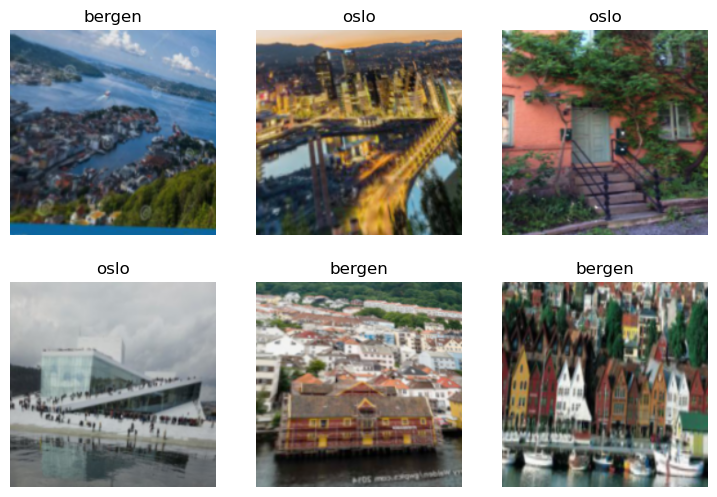

In [16]:
dls.show_batch(max_n=6)

# Model training

Let's fine-tune a pretrained ResNet model:

In [17]:
learn = vision_learner(dls, resnet18, metrics=error_rate)

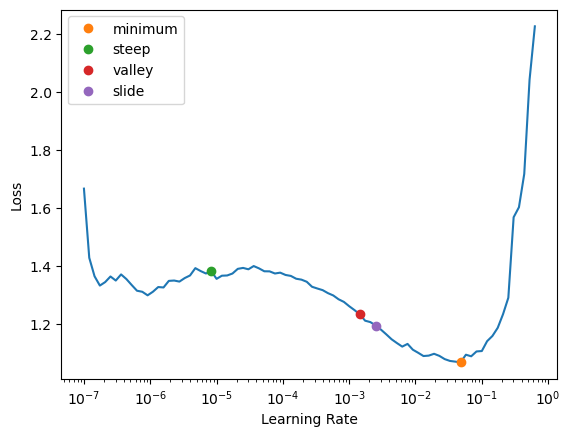

In [18]:
lr = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [19]:
learn.fine_tune(4, base_lr=lr.slide)

epoch,train_loss,valid_loss,error_rate,time


epoch,train_loss,valid_loss,error_rate,time
0,0.622660,0.566059,0.208763,00:03
1,0.523662,0.548139,0.177835,00:03
2,0.376901,0.447643,0.154639,00:03
3,0.304735,0.438905,0.139175,00:03


Here are some results on the validation set:

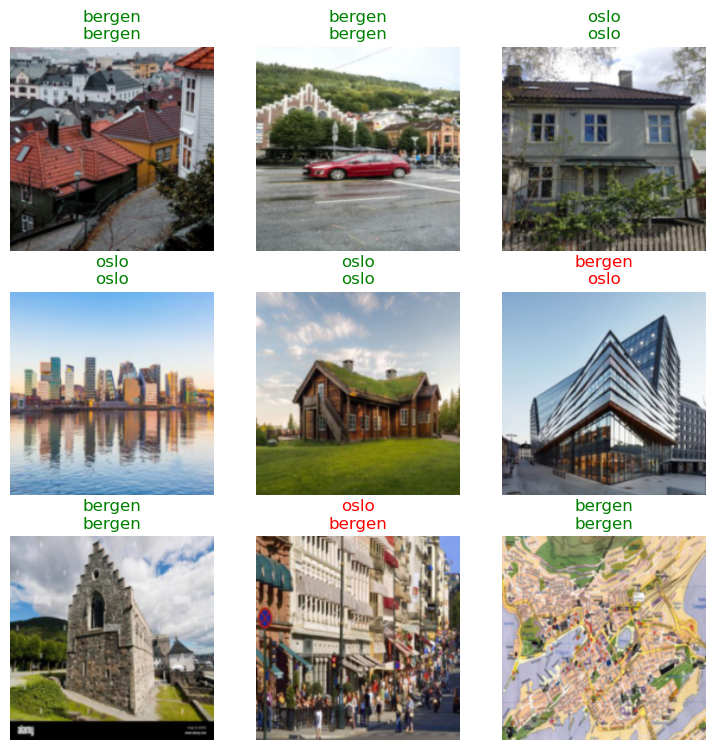

In [21]:
learn.show_results()

## Using models to clean data

`fastai` has a handy widget for cleaning data using a trained model. The idea is to show the highest loss images to the user, and then let them decide whether to delete or reclassify them or not. This can often catch unwanted and misclassified images.

> **Note:** There is a bug in the current version of the `ImageClassifierCleaner` having to do with the color formats of the images. The workaround is to convert the images to RGB format before passing them to the cleaner. This is done by modifying the function `_open_thumb` from `fastai.vision.widgets` below. 

In [22]:
import fastai
from fastai.vision.widgets import ImageClassifierCleaner

In [23]:
from PIL import Image

def _open_thumb(
    fn: Path|str, # A path of an image
    h: int, # Thumbnail Height
    w: int # Thumbnail Width
) -> Image: # `PIL` image to display
    "Opens an image path and returns the thumbnail of the image"
    return Image.open(fn).to_thumb(h, w).convert('RGB') # Changed from RGBA to RGB


In [24]:
# Replace the original function
fastai.vision.widgets._open_thumb = _open_thumb

In [25]:
cleaner = ImageClassifierCleaner(learn, max_n=25)

In [26]:
cleaner

## Retraining the model on cleaned data

In [108]:
dls = db.dataloaders(path, bs=64)

In [109]:
learn = vision_learner(dls, resnet18, metrics=error_rate)

In [110]:
learn.fine_tune(5, base_lr=lr.slide)

epoch,train_loss,valid_loss,error_rate,time
0,0.967323,0.697099,0.218509,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.680499,0.552723,0.226221,00:02
1,0.559100,0.491792,0.172237,00:02
2,0.459166,0.401630,0.143959,00:02
3,0.358132,0.468445,0.167095,00:02
4,0.293380,0.429882,0.151671,00:02


# Model evaluation

**NB: There are probably many duplicates in the data set, so the accuracy is probably higher than it should be.** If you want to be more careful, make sure that there are no images that appear both in the training and validation sets.

In [26]:
interp = ClassificationInterpretation.from_learner(learn)

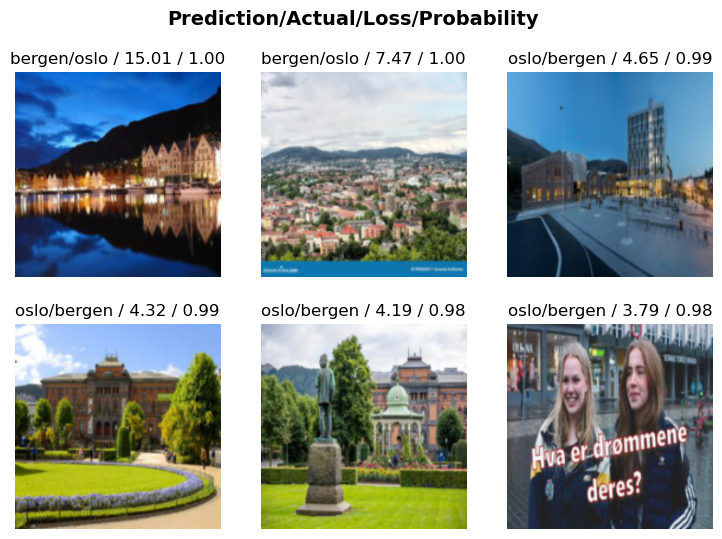

In [27]:
interp.plot_top_losses(6)

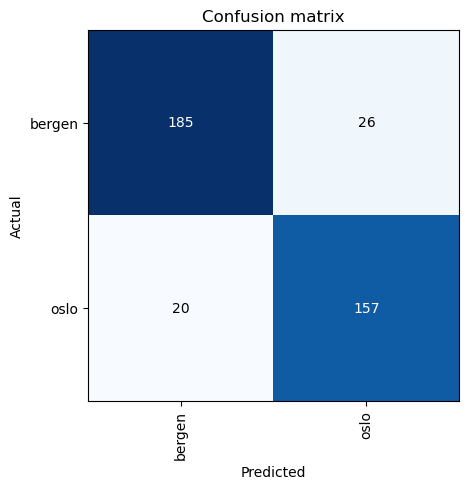

In [28]:
interp.plot_confusion_matrix()

In [29]:
interp.print_classification_report()

              precision    recall  f1-score   support

      bergen       0.90      0.88      0.89       211
        oslo       0.86      0.89      0.87       177

    accuracy                           0.88       388
   macro avg       0.88      0.88      0.88       388
weighted avg       0.88      0.88      0.88       388



## Class activation maps

By extracting the gradients belonging to each of the classes in the data set as they flow into the final convolutional layer in the image, one can produce a heatmap that indicates where in the image the model based its predictions on.

<img src="https://raw.githubusercontent.com/HVL-ML/DAT255/main/nbs/assets/gradcam.png">

We'll learn more about this later, once we have a better understanding of artificial neural network architectures. See also https://github.com/fastai/fastbook/blob/master/18_CAM.ipynb. 

In [27]:
# See the file `some_utils.py` to check what's imported here to compute the gradcam maps.
# We'll look at how to implement such functionality later in the course.
%pip install -Uqq fastai_amalgam palettable matplotlib_venn
from some_utils import *

Note: you may need to restart the kernel to use updated packages.


In [28]:
from some_utils import *

In [29]:
val_images = dls.valid.items
val_images[:3]

[Path('/home/alex/data/dat255/oslo_or_bergen/oslo/e73191bd-5ee4-4484-a49a-24af45ee4fde.jpg'),
 Path('/home/alex/data/dat255/oslo_or_bergen/oslo/29d826f7-6b8b-4bae-8e25-8ee2f2606e5d.jpg'),
 Path('/home/alex/data/dat255/oslo_or_bergen/bergen/b0f99ad3-b60e-484a-8c1c-bf5effb19149.jpg')]

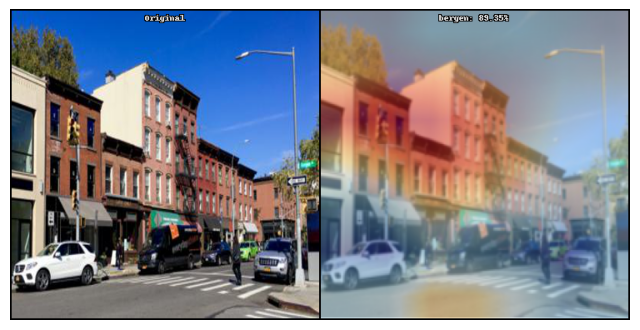

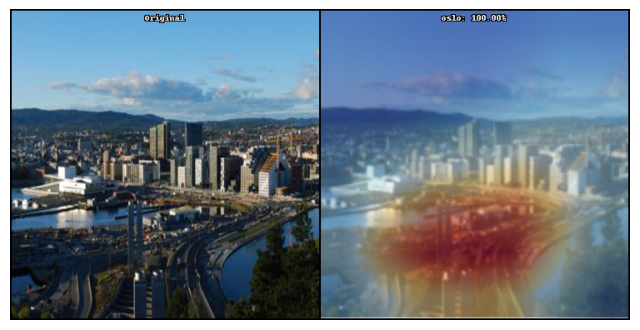

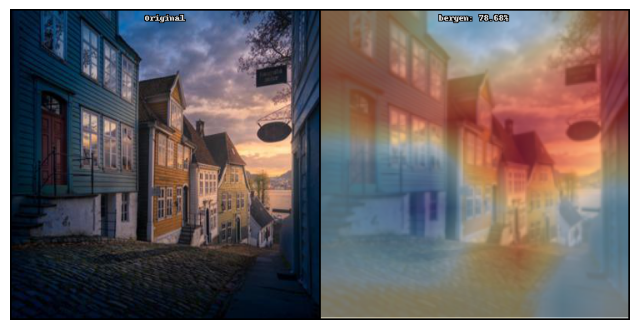

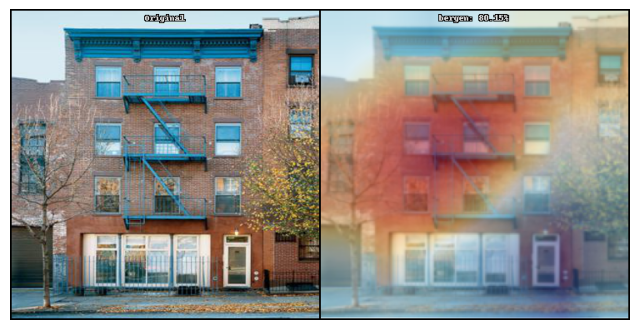

In [36]:
for img_fn in random.choices(val_images, k=4):
    gcam = gradcam(learn, str(path/img_fn), show_original=True)
    f = plt.figure(figsize=(8,6))
    plt.imshow(gcam)
    plt.axis('off')
    plt.show()

# Model deployment

We can deploy our model to HuggingFace Spaces using Gradio. See here for more details: https://www.tanishq.ai/blog/posts/2021-11-16-gradio-huggingface.html. 

> Many of you will remember Gradio from the course [DAT158](https://github.com/HVL-ML/DAT158). You can look back to what we discussed there to get some ideas for how to design your Gradio app. 

## Export model

In [30]:
learn.export()

## Import model

In [1]:
from fastai.vision.all import *

In [2]:
learn = load_learner('export.pkl')

## Create a Gradio interface

In [31]:
%pip install -Uqq gradio

Note: you may need to restart the kernel to use updated packages.


In [32]:
labels = learn.dls.vocab
def classify_image(img):
    pred,pred_idx,probs = learn.predict(img)
    return dict(zip(labels, probs))

In [36]:
import gradio as gr

image_input = gr.components.Image()
label_output = gr.components.Label()

examples = [f"assets/{fn}" for fn in ["bergen.jpg", "oslo.jpg", "newyork.jpg"]]


iface = gr.Interface(
    fn=classify_image, 
    inputs=image_input, 
    outputs=label_output, 
    examples=examples
    )

INFO:httpx:HTTP Request: GET https://api.gradio.app/pkg-version "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.gradio.app/gradio-initiated-analytics/ "HTTP/1.1 200 OK"


In [37]:

iface.launch(share=True)

INFO:httpx:HTTP Request: GET http://127.0.0.1:7861/startup-events "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD http://127.0.0.1:7861/ "HTTP/1.1 200 OK"


Running on local URL:  http://127.0.0.1:7861


INFO:httpx:HTTP Request: GET https://api.gradio.app/v2/tunnel-request "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://cdn-media.huggingface.co/frpc-gradio-0.2/frpc_linux_amd64 "HTTP/1.1 200 OK"


Running on public URL: https://a91da730bac6b74596.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


INFO:httpx:HTTP Request: HEAD https://a91da730bac6b74596.gradio.live "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.gradio.app/gradio-launched-telemetry/ "HTTP/1.1 200 OK"


> **Your turn!** Modify the Gradio app so that it shows the class activation map in addition the the prediction.

Let's deploy our app on Gradio. To do that, we make a Python script containing only the code necessary to run the app. Here's the complete code that we need (copied from above):

In [ ]:
# Import the necessary libraries
from fastai.vision.all import *
import gradio as gr

# Load the trained model
learn = load_learner('export.pkl')

# Get the labels from the model's dataloader
labels = learn.dls.vocab

# Function to classify an image using the model
def classify_image(img):
    pred,pred_idx,probs = learn.predict(img)
    return dict(zip(labels, probs))


# Create the Gradio interface
image_input = gr.components.Image()
label_output = gr.components.Label()

examples = [f"assets/{fn}" for fn in ["bergen.jpg", "oslo.jpg", "newyork.jpg"]]

iface = gr.Interface(
    fn=classify_image, 
    inputs=image_input, 
    outputs=label_output, 
    examples=examples
    )

iface.launch(inline=False)

Next, we follow the instructions to set up a HuggingFace Spaces https://huggingface.co/spaces

https://huggingface.co/spaces/HVL-ML/DAT255-first-demo

<img src="https://raw.githubusercontent.com/HVL-ML/DAT255/main/nbs/assets/hf_spaces_example.png">